# Practical 3: Neural Radiance Fields (NeRF)
---


Based on the [implementation](https://github.com/matsuren/nerf_jax_flax_practice) of NeRF by Ren Komatsu.

# Introduction

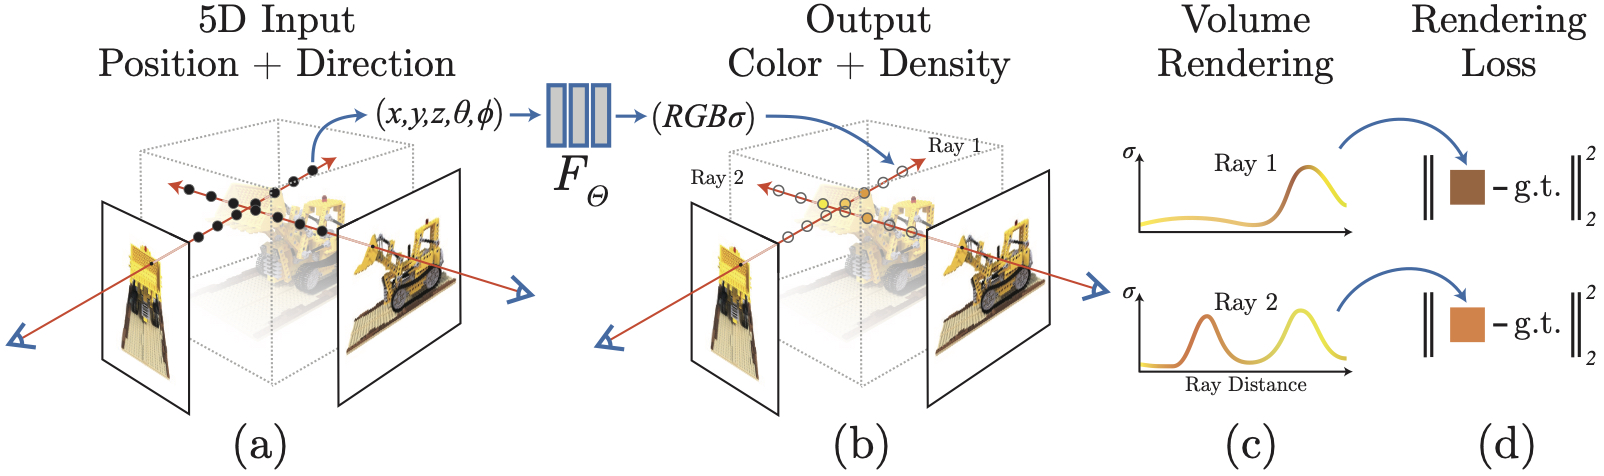

Welcome to the world of NeRF, or Neural Radiance Fields, a revolutionary 3D rendering technique developed by UC Berkeley. By using deep learning, NeRF converts 2D images into lifelike 3D scenes, capturing intricate details and realistic lighting effects. Its unique ability to model continuous volumetric scenes sets it apart from traditional methods, paving the way for applications in virtual reality, gaming, filmmaking, and more.

Ready to embark on this exciting journey? The official codebase, complete with everything you need to begin, is available on [GitHub](https://github.com/bmild/nerf). Let's get started! 🚀

But what is NeRF ?

As explained in the [paper](https://arxiv.org/abs/2003.08934), the algorithm represents a scene using a fully-connected (non-convolutional) deep network, whose
- input is a single continuous 5D coordinate (spatial location (x, y, z) and viewing direction (θ, φ)) and whose
- output is the volume density (σ) and view-dependent emitted radiance (RGB) at that spatial location.

# Setup

## Install and Import Packages

In [ ]:
! pip install flax -q
! pip install optax -q
! pip install dm_haiku -q
! pip install ml_collections -q

Import Libraries


In [ ]:
import json
import os
from collections import defaultdict

from functools import partial
from time import time
from random import sample as sample_no_duplicates

import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm
import pickle

import cv2
import jax
import jax.numpy as jnp
from jax import jit
from jax import numpy as jnp
from jax import random
from jax import value_and_grad as vgrad
from jax import grad, jit, random, value_and_grad, vmap
from flax import linen as nn
import optax
import haiku as hk
import tensorflow as tf

from mpl_toolkits.mplot3d import Axes3D



# Data

## Dataset Handling and Configurations
Create a dictionary for settings using the `ml_collections` library.

In [ ]:
from ml_collections import ConfigDict
cfg={
    "gpu_id": 0,
    "lr": 0.001,
    "num_epochs": 200,
    "comments": "Final model + use 3D for view dir",
    "near_clip": 2.0,
    "far_clip": 6.0,
    "ray_sample": 32,
    "fine_ray_sample": 64,
    "encode_num": 10,
    "encode_num_view": 4,
    "layer_num": 6,
    "hidden_ch": 128,
    "dataset_type": "NERF",
    "dataset": "nerf_example",
    "half_res": True,
    "testset_num": 32,
    "workers": 2,
}
cfg = ConfigDict(cfg)
cfg

In [ ]:
if not os.path.exists('./results'):
    print("Created `./results` directory")
    os.mkdir('./results')
if not os.path.exists('./checkpoints'):
    print("Created `./checkpoints` directory")
    os.mkdir('./checkpoints')

In [ ]:
DATASET = cfg.dataset
DATASET

**Download** the data from the origal repository.

In [ ]:
if not os.path.exists('data/'):
    # Load dataset using official script
    !wget https://raw.githubusercontent.com/bmild/nerf/master/download_example_data.sh
    !bash download_example_data.sh

Create Dataloaders

In [ ]:
from os.path import join
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

class NeRFDataset(Dataset):
    object_names = [
        "chair",
        "drums",
        "ficus",
        "hotdog",
        "lego",
        "materials",
        "mic",
        "ship",
    ]

    def __init__(self, root_dir, split_type="train", transform=None, half_res=False):
        # Load data
        self.root_dir = root_dir
        self.half_res = half_res
        json_filename = join(self.root_dir, f"transforms_{split_type}.json")
        with open(json_filename) as f:
            json_data = json.load(f)

        self.samples = []
        for frame in json_data["frames"]:
            img_fname = join(self.root_dir, frame["file_path"] + ".png")

            pose = np.array(frame["transform_matrix"])
            # Adjust poses so that camera front is z+
            T = np.eye(3)
            T[1, 1] = -1
            T[2, 2] = -1
            pose[:3, :3] = pose[:3, :3].dot(T)
            self.samples.append((img_fname, pose))

        # focal length
        img = self.load_image(img_fname)
        h, w = img.shape[:2]
        camera_angle_x = float(json_data["camera_angle_x"])
        self.focal = 0.5 * w / np.tan(0.5 * camera_angle_x)

        self.transform = transform

    def load_image(self, img_fname):
        img = cv2.imread(img_fname, cv2.IMREAD_UNCHANGED)
        # Downsample
        if self.half_res:
            img = cv2.resize(img, (0, 0), fx=0.5, fy=0.5)
        img = img.astype(np.float32) / 255.0

        if img.shape[2] == 4:
            # Add arbitrary background color for image with alpha
            bkg = np.array([1.0, 1.0, 1.0], dtype=np.float32)
            img_rgb = img[..., :3]
            img_alpha = img[..., 3:]
            img = img_rgb*img_alpha + bkg*(1.-img_alpha)
        # BGR to RGB
        img = np.array(img[...,::-1])
        return img

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_fname, pose = self.samples[idx]
        img = self.load_image(img_fname)
        sample = {"img": img, "pose": pose}
        if self.transform:
            sample = self.transform(sample)
        sample["focal"] = self.focal
        return sample

## Data Visualization

In [ ]:
from torch.utils.data import Subset
print("Dataset type:", DATASET)

root_dir = './data/nerf_synthetic/lego'
if not os.path.split(root_dir)[-1] in NeRFDataset.object_names:
    print("The object might not be included")
trainset = NeRFDataset(root_dir, split_type="train", half_res=cfg.half_res)
all_testset = NeRFDataset(root_dir, split_type="test", half_res=cfg.half_res)

if cfg.testset_num > 0:
    testset = Subset(all_testset, range(cfg.testset_num))
else:
    testset = all_testset

print(f"Dataset size:", len(trainset), len(testset))

Lets **preview** an image from the training set !

As we can see, each sample has the following *keys of interest*:

In [ ]:
# Load data
sample = trainset[0] # randomly select an index

for key, item in sample.items():
    print(key, item.shape)

Lets further dive into these attributes

In [ ]:
# Get the attributes of interest
img = sample['img'] # image itself
pose = sample['pose'] # the transformation matrix with shape (4,4)
focal = sample['focal'] # focal length

In [ ]:
# Preview the image
plt.imshow(img)

Inspect the other attributes

In [ ]:
print("focal:", focal)
print("pose shape:", pose.shape)
print("pose:", pose)

**Focal** : Focal length is the distance between your camera’s sensor and the lens’s point of sharpest focus when focusing the camera to infinity.

### Camera Coordinate System to World Coordinate System

Say the pose transformation is called
$$ T = \begin{bmatrix}
R & \vec t\\  
0 & 1
\end{bmatrix}$$

- $\vec{t}$ can be interpreted as a vector from the origin of the world coordinate system to the camera's position in world coordinates. In other words, it's the position of the camera in world coordinates.
- $R$ is the rotation of the camera coordinates to arrive at the world coordinates, after the translation is applied (i.e. a centered rotation). In other words, this describes the direction in which the camera points.

So, to map from camera coordinates to world coordinates:
$$\vec p_{world} = T \cdot \vec p_{camera} = R ⋅ \vec p_{camera} + \vec t$$

In the context of NeRF, these are essential for determining **the viewpoint from which rays are cast into the scene**.


Note that $\vec{p}$ is a column vector. If we wanted to use a row vector (e.g. for batching multiple $\vec{p}_{camera}$vectors) then we would transform the equation above such as:
$$ \vec p_{world\ batched} = \vec p_{camera\ batched}^T ⋅ R^T + \vec t^T$$

In [ ]:
rotation = pose[:3,:3]
translation = pose[:3,3]
print("Rotation Vector:\n", rotation, "\n") # rotation vector
print("Translation Vector:\n", translation) # translation vector

Compute the variable `camera_bnd_max`, which calculates the **maximum absolute value** among the **maximum and minimum camera positions**.

In [ ]:
# Translation values band for every training sample.
camera_bnd = np.array([it['pose'][:3, 3] for it in trainset])

print("Camera position range")
print("Max:", camera_bnd.max())
print("Min:", camera_bnd.min())

# Compute the maximum absolute value.
camera_bnd_max = max(abs(camera_bnd.max()),
                     abs(camera_bnd.min()))

print("\nMaximum Absolute Value:", camera_bnd_max)

 This represents the **furthest distance from the origin along any axis**, and it will be useful for understanding the spatial extent of the camera positions.

Now, let's create a function to visualize data using a transformation matrix `T` and `scale`.

The resulting plot would show the three axes of a coordinate system, oriented according to the pose matrix and scaled by the scale factor. This could be useful in visualizing the orientation and position of a 3D object or coordinate frame.

In [ ]:
def drawAxis(T=np.eye(4), scale=0.3, colors=["r", "g", "b"], ax=None):
    ### YOUR CODE HERE #########################
    # Create a new 3D axis object if not provided
    if ax is None:
        fig = ...
        ax = ...

    tvec = ...  # translation, default = [0,0,0]
    R = ...  # rotation, default [[1,0,0],[0,1,0],[0,0,1]]

    # Compute the starting points of axis, using translation
    # We should flatten, add new axis and repeat for each dimension
    start = ...
    # Compute the endpoints of each axes after applying rotation and translation
    end = ...
    for s, e, c in zip(start, end, colors):
        # draw an axis
        ...
    ############################################


In [ ]:
drawAxis(scale=0.5)

**Dataloaders**

`collate_fn`: Specify how data should be batched together. For each item in the batch, stack all items into an array based on their keys.

In [ ]:
def collate_fn(batch):
    sample = {key: [] for key in batch[0].keys()}
    for it in batch:
        for key, val in it.items():
            sample[key].append(val)
    sample = {key: np.stack(val) for key, val in sample.items()}
    return sample


In [ ]:
collated = collate_fn([trainset[0], trainset[1]])
jax.tree_util.tree_map_with_path(lambda path, a: print(path, a.shape, a.dtype), collated);

In [ ]:
# Get data from batch
batch_iterator = iter(DataLoader(trainset, batch_size=32, shuffle=False, collate_fn=collate_fn))
batch = next(batch_iterator)
batch.keys()

In [ ]:
imgs = batch["img"]
poses = batch["pose"]

Plot images aligned with the 3D-axis.

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(30, 30))

for i in range(4):
    ax = axes[i]
    ax.imshow(imgs[i])
    drawAxis(poses[i], scale=100, ax=ax)

plt.show()


## Camera pose generation

Create two functions, `spherical_to_xyz` and `xyz_to_spherical` for convertion between spherical and Cartesian (XYZ) coordinates

1. **Spherical to Cartesian (`spherical_to_xyz`)**:
   - **Input**: Spherical coordinates $(r, \theta, \phi)$\:, where $r$ is the radial distance, $\theta$ is the polar angle (angle from the positive z-axis), and $\phi$ is the azimuthal angle (angle from the positive x-axis).
   - **Process**:
     - $x = r \cdot \sin(\theta) \cdot \cos(\phi)$
     - $y = r \cdot \sin(\theta) \cdot \sin(\phi)$
     - $z = r \cdot \cos(\theta)$
   - **Output**: Cartesian coordinates (x, y, z).

In [ ]:
def spherical_to_xyz(r, theta, phi):
    assert theta.shape == phi.shape == r.shape
    ### YOUR CODE HERE #########################
    # Convert each coordinate using jnp and the the equations above
    x = ...
    y = ...
    z = ...

    # Stack the new coordinates
    return ...
    ############################################


2. **Cartesian to Spherical (`xyz_to_spherical`)**:
   - **Input**: Cartesian coordinates $(x, y, z)$.
   - **Process**:
     - Compute the length of the projection of the point onto the XY-plane: `len_xy = jnp.hypot(x, y)`.
     - Compute the radial distance: $r = \sqrt{z^2 + \text{{len\_xy}}^2}$.
     - Compute the polar angle: $\theta = \arctan2(z, \text{{len\_xy}})$.
     - Compute the azimuthal angle: $\phi = \arctan2(y, x)$.
   - **Output**: Spherical coordinates $(r, \theta, \phi)$.


In [ ]:
def xyz_to_spherical(pts):
    x = pts[..., 0]
    y = pts[..., 1]
    z = pts[..., 2]

    len_xy = jnp.hypot(x, y)
    r = jnp.hypot(z, len_xy)
    theta = jnp.arctan2(z, len_xy)
    phi = jnp.arctan2(y, x)
    return r, theta, phi

The `get_camera_poses` function generates camera poses (positions and orientations) in a 3D space based on spherical coordinates $(r, \theta, \phi)$ and constructs $4\times4$ transformation matrices that represent these poses.

In [ ]:
def get_camera_poses(r, theta, phi,
                     lookat=np.array([0, 0, 0.5]),
                     up=np.array([0, 0, 1])):
    """
    Computes the transformation matrix for camera positions based on spherical coordinates and orientation details.

    Parameters:
    - r, theta, phi: Spherical coordinates representing the camera position.
    - lookat: Point in space the camera is looking at.
    - up: Upward direction vector for the camera.

    Returns:
    - T_wc: Transformation matrix from camera coordinates to world coordinates.
    """

    # Convert spherical coordinates to Cartesian (x, y, z) coordinates
    # to get the camera's position in the world coordinate system.
    camera_translation_vector = spherical_to_xyz(r, theta, phi)

    # Compute the direction in which the camera is pointing by subtracting
    # the camera position from the lookat point. This gives the forward direction or z-axis.
    zaxis = lookat - camera_translation_vector
    # Normalize the z-axis vector to have unit length.
    zaxis /= np.linalg.norm(zaxis, axis=-1, keepdims=True)

    # Compute the x-axis of the camera coordinate system by taking the cross product
    # of the z-axis and the up vector.
    xaxis = np.cross(zaxis, up)
    # Normalize the x-axis vector to have unit length.
    xaxis /= np.linalg.norm(xaxis, axis=-1, keepdims=True)

    # Compute the y-axis of the camera coordinate system by taking the cross product
    # of the z-axis and the x-axis. It is perpendicular to both z-axis and x-axis.
    yaxis = np.cross(zaxis, xaxis)

    # Stack x, y, and z axes together to form the rotation matrix for the camera.
    camera_rotation_vector = np.stack([xaxis, yaxis, zaxis], axis=-1)

    # Initialize the transformation matrix T_wc with identity matrices.
    # This matrix transforms from camera coordinates to world coordinates.
    T_wc = np.array(
        [np.eye(4) for _ in range(camera_translation_vector.shape[0])])

    # Set the rotation part of the transformation matrix using the camera rotation matrix.
    T_wc[..., :3, :3] = camera_rotation_vector
    # Set the translation part of the transformation matrix using the camera position.
    T_wc[..., :3, 3] = camera_translation_vector

    # Return the transformation matrix.
    return T_wc


Create 10 poses with:

- radius $r = 3.5$
- $\theta = 80° $ in radians
- $\phi ∈ (-180°, 180° )$ in radians

In [ ]:
pose_num = 10

r = np.full((pose_num), 3.5)
theta = np.full((pose_num), np.deg2rad(80))
phi = np.linspace(-np.pi, np.pi, pose_num, endpoint=False)

# Create camera points (translation vectors)
cam_pts = spherical_to_xyz(r, theta, phi)

# Create camera poses (rotation + translation vector)
cam_poses = get_camera_poses(r, theta, phi)

# 3D Plot
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
c = ["c", "y", "k", "b"]

# draw origin (T=eye(4))
drawAxis(ax=ax)
# draw each camera pose
for i, pose in enumerate(cam_poses):
    colors = ["r", "g", c[i % len(c)]]
    drawAxis(pose, 0.6, colors, ax=ax)

# adjust scale
scale = 7
start = np.zeros((3, 3)) - scale / 2
end = start + scale * np.eye(3)
for s, e in zip(start, end):
    ax.plot([s[0], e[0]], [s[1], e[1]], [s[2], e[2]], c="none")
plt.show()


### Lets Visualize the Camera
Setting up the camera's intrinsic parameters and computing the normalized direction of rays emanating from the camera's pinhole (or optical center) and passing through each pixel in the image


In [ ]:
height, width, ch = imgs.shape[1:]

# Center for x and y coordinates
cx = width / 2
cy = height / 2
print(f"image height:{height}, width:{width}, f:{focal:.2f}, cx:{cx:.2f}, cy:{cy:.2f}")

# ray direction from cam
x_grid = np.arange(width) - cx + 0.5 # (400,) from (-199.5, -198.5, ...., 199.5)
y_grid = np.arange(height) - cy + 0.5 # (400,) from (-199.5, -198.5, ...., 199.5)
x_grid, y_grid = np.meshgrid(x_grid, y_grid)
ray_cam = np.stack([x_grid, y_grid, np.full_like(x_grid, focal)], axis=-1)

# TODO divided by norm or z
ray_cam /= np.linalg.norm(ray_cam, axis=-1, keepdims=True)
ray_tmp = ray_cam[::10, ::10]  # For debug

The resulting world-space rays are scattered in the plot.

In [ ]:
# 3D Plot
fig = plt.figure(figsize=(6, 6))
ax = Axes3D(fig)
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

c = ["c", "y", "k", "b"]

# Select a sample idx
i = 2

pose = poses[i]
colors = ["r", "g", c[i]]
drawAxis(pose, 1, colors, ax=ax)

# Camera optical center
t = pose[:3, 3]
# Cam coord to world coord rotation
R = pose[:3, :3]


### YOUR CODE HERE #########################
# Transform the row vector `ray_tmp` using the rotation matrix and the translation vector.
ray_world = ...
# Flatten the first two dimensions into one
ray_world = ...
# Plot (x,y,z) for each ray_world sample
ax.scatter(ray_world[:, 0], ray_world[:, 1], ray_world[:, 2])
############################################

# adjust scale
scale = 2
start = np.zeros((3, 3)) - scale / 2
end = start + scale * np.eye(3)
for s, e in zip(start, end):
    ax.plot([s[0], e[0]], [s[1], e[1]], [s[2], e[2]], c="none")


fig, ax = plt.subplots(1, 1, figsize=(10, 10))

plt.imshow(imgs[i])

# NeRF Architecture


## Positional Encoding

Authors use recent work by [Rahaman et al.](https://arxiv.org/abs/1806.08734), which shows that deep networks are biased towards learning lower frequency functions. They additionally show that mapping the inputs to a higher dimensional space using high frequency functions before passing them to the network enables better fitting of data that contains high frequency variation.


In [ ]:
def encode_variables(x, encode_num):

    # No positional encoding
    if encode_num == 0:
        return x

    # Positional encoding
    frequency_bands = 2.0 ** jnp.linspace(0.0, encode_num - 1, encode_num)
    encoded_grid = []
    for freq in frequency_bands:
        for func in [jnp.sin, jnp.cos]:
            encoded_grid.append(func(jnp.pi * x * freq))
    encoded_grid = jnp.concatenate(encoded_grid, axis=-1)

    return encoded_grid

## Model Definition

First, lets generate a random key.

In [ ]:
# Generate key which is used to generate random numbers
rng = random.PRNGKey(0)

Set dimensions

In [ ]:
ch_dim = 3
view_dim = 3

Split the random key and create a random sample `x`

In [ ]:
### YOUR CODE HERE #########################
# Split the original key into two keys using jax.random
rng, k1 = ...
# Create a random sample following normal distribution with shape (ch_dim + view_dim,)
x = ...
############################################

The overall NeRF architecture, using the positional encoding of γ(x) and γ(d)

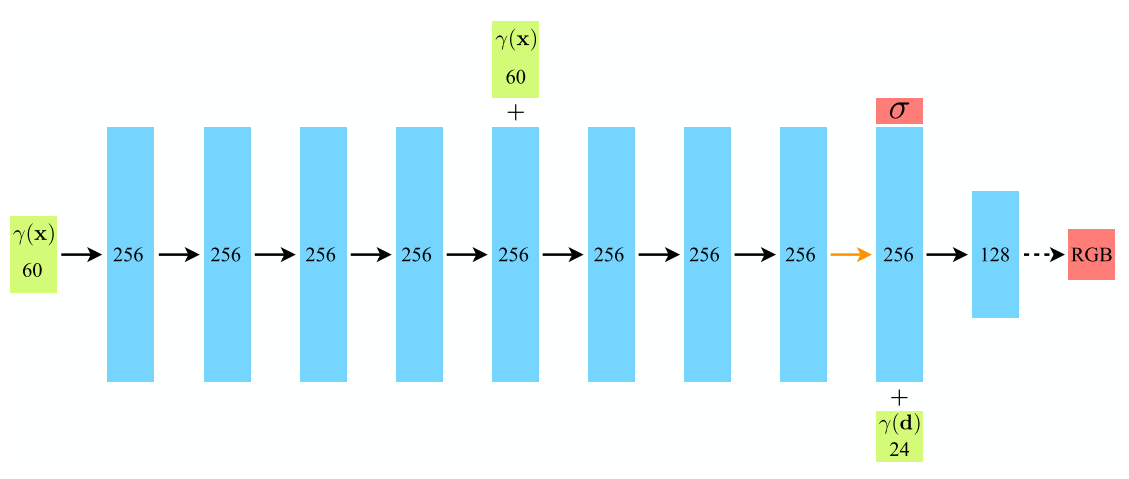

Let's implement this in haiku

In [ ]:
import haiku as hk
import jax
import jax.numpy as jnp

class NeRF(hk.Module):
    def __init__(self, layer_num, hidden_ch, encode_num, encode_num_view, skips=(4,)):
        super().__init__()
        self.layer_num = layer_num
        self.hidden_ch = hidden_ch
        self.encode_num = encode_num
        self.encode_num_view = encode_num_view
        self.skips = skips

    def __call__(self, x):
        # Encode input
        xyz = x[:3]
        view = x[3:]
        ### YOUR CODE HERE #########################
        # Use encode_variables to encode both xyz and view, to the corresponding encoding_num.
        xyz = ...
        view = ...


        # fc
        x = xyz
        for i in range(self.layer_num):
            if i in self.skips:
                # Skip connection
                x = ...
            # Linear connection to hidden_ch dimension
            x = ...
            # Relu non linearity
            x = ...

        # sigma
        # Get sigma here
        sigma_out = ...
        sigma = jax.nn.relu(sigma_out)

        # rgb
        bottleneck = hk.Linear(self.hidden_ch, name="rgb_fc0")(x)
        # Concatenate with view now.
        x = ...
        # Compress from 256 to 128
        x = ...
        x = jax.nn.relu(x)
        # Go to the corresponding RGB dimension of 3 and squeeze to [0,1] using sigmoid
        x = ...
        rgb = ...
        ############################################
        return sigma, rgb



In [ ]:
# Define a function that creates and calls the model
def forward_fn(x):
    global cfg
    model = NeRF(layer_num=cfg.layer_num,
                 hidden_ch=cfg.hidden_ch,
                 encode_num=cfg.encode_num,
                 encode_num_view=cfg.encode_num_view)
    return model(x)

# Transform the function
forward = hk.transform(forward_fn) # with randomness eg for dropout
forward_det = hk.without_apply_rng(forward) # deterministic, without randomness

Initialize the model with 2 different `params` versions
- **Coarse** model: A low-resolution rendering providing an approximation of the scene.
- **Fine** model: A high-resolution rendering to refine the details.

In [ ]:
rng, k1, k2 = random.split(rng, num=3)
params = {}

### YOUR CODE HERE #########################
# Initialize the two networks based on the two random numbers you created.
params['coarse'] = ...
params['fine'] = ...


# Apply the model on x, using these params
out_coarse = ...
out_fine = ...
############################################

In [ ]:
# Lets preview the output of each model's forward pass
out_coarse, out_fine

**Visualize** weights and bias dims

In [ ]:
jax.tree_map(lambda x: x.shape, params)

In [ ]:
test_sample = testset[0]
test_img = test_sample['img']
test_pose = test_sample['pose']
plt.imshow(test_img)
print(test_pose)

In [ ]:
print("train images number:", len(trainset))
print("test images number:", len(testset))

trainloader = DataLoader(
    trainset, batch_size=1, shuffle=True, collate_fn=collate_fn, num_workers=cfg.workers
)
testloader = DataLoader(
    testset, batch_size=1, shuffle=False, collate_fn=collate_fn, num_workers=cfg.workers
)

# pixel ray direction in cam coord
ray_dir_cam = jnp.asarray(ray_cam)
ray_dist = jnp.linspace(cfg.near_clip, cfg.far_clip, cfg.ray_sample)

In [ ]:
def prediction(params, x):
    ### YOUR CODE HERE #########################
    # Apply the deterministic model to x, using the params passed
    sigma, rgb = ...
    ############################################
    return sigma, rgb

Example of forward pass for **coarse** model

In [ ]:
x = jnp.ones((ch_dim + view_dim, ))
sigma, rgb = prediction(params["coarse"], x)
sigma, rgb

Define a **vectorized version** (batched) of the prediction function to apply along a ray

In [ ]:
### YOUR CODE HERE #########################
# Create a vectorized version for the prediction function
ray_prediction = ...
ray_prediction
############################################

## Stratified Sampling and Rendering

### Function to Sample Points along a Ray

In [ ]:
def _sample_points(ray_dir, t, ray_dist, camera_bnd=6.0):
    # Multiply ray direction by distances and add origin t to get 3D points along the ray
    pts = ray_dist[..., None] * ray_dir + t

    # Normalize the points by the camera boundary to prepare for positional encoding
    pts = pts / camera_bnd

    # Concatenate points with ray direction in Cartesian coordinates
    pts = jnp.concatenate([pts, ray_dir[None].repeat(pts.shape[0], 0)], axis=-1)

    # Calculate distances between consecutive sampled points along the ray
    dists = ray_dist[1:] - ray_dist[:-1]
    dists = jnp.pad(dists, (0, 1), 'constant', constant_values=(1e10))

    return pts, dists

Create a "partial" version of the `_sample_points` function where the `camera_bnd` parameter is fixed at `camera_bnd_max`. Any subsequent calls to `sample_points` will automatically use this value for the `camera_bnd` parameter, without needing to specify it each time.

In [ ]:
sample_points = partial(_sample_points, camera_bnd=camera_bnd_max)
sample_points

### Function to Integrate Color Along a Ray

In [ ]:
def integrate_color(sigma, rgb, dists, bkg=jnp.array([1.0, 1.0, 1.0])):
    # Compute transparency for each sampled point along the ray based on density (sigma) and distances
    transparency = jnp.exp(-sigma.squeeze() * dists)

    # Compute alpha (opacity) as the complement of transparency
    alpha = 1 - transparency

    # Compute exclusive cumulative product of transparency to model accumulated transparency along the ray
    T = jnp.cumprod(transparency)[:-1]
    T = jnp.pad(T, (1, 0), 'constant', constant_values=1)

    # Compute weights for each sampled point based on alpha and accumulated transparency
    weights = alpha[..., None] * T[..., None]

    # Weight the colors by the computed weights
    colors = rgb * weights

    # Sum the weighted colors and blend with background color based on remaining transparency
    colors = colors.sum(axis=0) + bkg * (1.0 - weights.sum())

    return colors, weights


In [ ]:
def render_ray(params, ray_dir, t, ray_dist):
    # Sample 3D points and distances along a given ray
    pts, dists = sample_points(ray_dir, t, ray_dist)

    # Predict density (sigma) and color (rgb) for the sampled points using the neural network
    sigma, rgb = ray_prediction(params, pts)

    # Integrate the color along the ray, taking into account the density, color, and distances
    colors, weights = integrate_color(sigma, rgb, dists)

    # Return the computed colors and weights for the ray
    return colors, weights

Define a **vectorized version** (batched) of render_ray to apply to multiple rays simultaneously. *Useful for rendering a whole image (grid of rays) in parallel*

In [ ]:
render_pixels = vmap(render_ray, in_axes=(None, 0, None, None))

### Sample points according to a given probability distribution defined by the weights.
This function takes the weights representing importance along a ray and returns indices and factors for linear interpolation. It ensures that more meaningful or important parts of the ray are sampled more densely.

In [ ]:
def sample_pdf(weights, sample_num):
    # Add small constant to weights to avoid division by zero
    weights = weights + 1e-5

    # Compute probability density function (PDF) by normalizing weights
    pdf = weights / weights.sum()

    # Compute cumulative density function (CDF) for importance sampling
    cdf = jnp.cumsum(pdf)

    # Create uniform probability samples, excluding the start and end points
    start = 1 / (sample_num + 1)
    end = 1 - start
    uniform_prob = jnp.linspace(start, end, sample_num)

    # Find indices in CDF corresponding to uniform samples
    right_idx = jnp.searchsorted(cdf, uniform_prob, side='right')
    left_idx = right_idx - 1

    # Perform linear interpolation to compute fine sample positions
    right_factor = (uniform_prob - cdf[left_idx]) / (cdf[right_idx] - cdf[left_idx])
    left_factor = 1.0 - right_factor

    return left_idx, left_factor



### Render a single ray at finer intervals using importance sampling.
This function takes the parameters of the neural radiance field, weights for importance sampling, ray direction, number of fine samples, ray origin, and ray distances. It then uses importance sampling to select more meaningful points along the ray and integrates the predicted colors and densities at those points to render the final color for the ray.

In [ ]:
def render_ray_fine(params, weights, ray_dir, fine_ray_sample, t, ray_dist):
    # Perform importance sampling on ray using PDF derived from weights
    l_idx, l_factor = sample_pdf(weights, fine_ray_sample)
    fine_ray_dist = l_factor * ray_dist[l_idx] + (1 - l_factor) * ray_dist[l_idx + 1]

    # Prevent gradient from propagating through the fine sampling
    fine_ray_dist = jax.lax.stop_gradient(fine_ray_dist)

    # Sample points and distances along the ray at fine intervals
    pts, dists = sample_points(ray_dir, t, fine_ray_dist)

    # Predict density (sigma) and color (rgb) for the sampled points
    sigma, rgb = ray_prediction(params, pts)

    # Integrate the color along the ray based on density, color, and distances
    colors, weights = integrate_color(sigma, rgb, dists)

    return colors, weights

In [ ]:
# Vectorize render_ray_fine to apply to multiple rays simultaneously
render_pixels_fine = vmap(render_ray_fine, in_axes=(None, 0, 0, None, None, None))


### Perform both coarse and fine rendering for a batch of rays

In [ ]:
# jitted for performance
@partial(jit, static_argnums=2)
def render_pixels_coarse_fine(params, batch_dirs, fine_ray_sample, t, ray_dist):
    # Coarse Sampling:
    # Render the pixels using the coarse parameters, resulting in coarse_colors and weights
    # The coarse rendering provides an initial estimate and importance weights for fine rendering
    coarse_colors, weights = render_pixels(params['coarse'], batch_dirs, t, ray_dist)

    # Fine Sampling:
    # Render the pixels again using the fine parameters, guided by the weights from coarse rendering
    # The fine rendering refines the initial estimate to produce more accurate colors
    fine_colors, _ = render_pixels_fine(
        params['fine'], weights, batch_dirs, fine_ray_sample, t, ray_dist
    )

    # Return both fine and coarse colors for comparison or further processing
    return fine_colors, coarse_colors


**Loss** is simply the total squared error between the rendered $\hat{C(r)}$ and true pixel $C(r)$ colors for both the coarse $\hat{C_c(r)}$  and fine $\hat{C_f(r)}$ renderings:


$$ \mathcal{L} = ∑_{r∈R} [\ {\| \hat{C_{c}(r)} - C(r) \|_2^2} + {\| \hat{C_{f}(r)} - C(r) \|_2^2}\  ]  $$

In [ ]:
def loss_fn(params, batch_dirs, batch_pixels, t, ray_dist, fine_ray_sample):
    ### YOUR CODE HERE #########################

    # Coarse and Fine Sampling:
    # Render the pixels for both coarse and fine resolutions using the provided parameters
    # batch_dirs contains the ray directions, t is the ray origin, and ray_dist contains the ray distances
    fine_colors, coarse_colors = ...

    # Calculate Coarse Loss:
    # Compute the mean squared error between the coarse rendered colors and the target pixels (batch_pixels)
    coarse_loss = ...

    # Calculate Fine Loss:
    # Compute the mean squared error between the fine rendered colors and the target pixels (batch_pixels)
    fine_loss = ...

    # Total Loss:
    # Combine coarse and fine losses to obtain the total loss for the current batch
    total_loss = ...

    ############################################

    # Return the total loss, which is used to train and optimize the Neural Radiance Field (NeRF) model
    return total_loss


In [ ]:
# Function to render an image from a given camera pose and ray directions
def render_image(params, pose, ray_dir_cam, fine_ray_sample):
    # Camera Optical Center:
    # Extract the translation part of the camera pose, representing the camera's position in world coordinates
    t = pose[:3, 3]

    # Camera to World Rotation:
    # Extract the rotation part of the camera pose, used to transform ray directions from camera to world coordinates
    R = pose[:3, :3]

    # Ray Direction in World Coordinates:
    # Transform ray directions from camera coordinates to world coordinates using the rotation matrix R
    ray_dir_world = ray_dir_cam.dot(R.T)
    flatten_ray_dir_world = ray_dir_world.reshape(-1, 3)

    # Initialize lists to store coarse and fine colors for each pixel
    coarse_colors = []
    fine_colors = []

    # Batch size for processing rays (to avoid GPU memory issues)
    batch_ray_num = 4096

    # Iterate through the rays in batches to render the image
    for pix_idx in range(0, len(flatten_ray_dir_world), batch_ray_num):
        # Extract batch of ray directions
        batch_dirs = flatten_ray_dir_world[pix_idx: pix_idx + batch_ray_num]

        # Coarse and Fine Sampling:
        # Render both coarse and fine colors for the current batch of rays
        fine, coarse = render_pixels_coarse_fine(
            params, batch_dirs, fine_ray_sample, t, ray_dist
        )
        coarse_colors.append(coarse)
        fine_colors.append(fine)

    # Convert Colors into 2D Image:
    # Concatenate and reshape the colors to form the final image, and clip values to the [0, 1] range
    coarse_img = jnp.concatenate(coarse_colors).reshape(ray_dir_cam.shape)
    coarse_img = jnp.clip(coarse_img, a_min=0.0, a_max=1.0)
    fine_img = jnp.concatenate(fine_colors).reshape(ray_dir_cam.shape)
    fine_img = jnp.clip(fine_img, a_min=0.0, a_max=1.0)

    # Return both fine and coarse images
    return fine_img, coarse_img


## Optimizer Setup

### Initialize Adam optimizer

In [ ]:
optimizer = optax.adam(learning_rate=cfg.lr)
optimizer_state = optimizer.init(params)

# Learning Rate (LR) Scheduler:
# Define a function to create an exponential learning rate schedule
def create_exponential_lr(initial_lr, decay_steps, decay_rate):
    def learning_rate_fn(step):
        # Compute learning rate by exponentially decaying the initial learning rate
        lr = initial_lr * decay_rate ** (step / decay_steps)
        return lr
    return learning_rate_fn

# Create an instance of the exponential LR scheduler
# Final learning rate is cfg.lr * 0.01
learning_rate_fn = create_exponential_lr(cfg.lr, len(trainloader) * cfg.num_epochs / 2, 0.1)

### Optimization Step Function

In [ ]:
# Define a function to perform a single optimization step
def _optim_step(epoch, params, optimizer_state, batch_dirs, batch_pixels,
                t, ray_dist, fine_ray_sample, learning_rate_fn):

    # Compute the loss and gradients using the current parameters
    loss_values, grads = value_and_grad(loss_fn)(
        params, batch_dirs, batch_pixels, t, ray_dist, fine_ray_sample)

    # Get the learning rate for the current epoch
    lr = learning_rate_fn(epoch)  # Assuming you manage steps through the count field

    # Compute parameter updates using the optimizer
    updates, new_optimizer_state = optimizer.update(grads, optimizer_state, params)

    # Apply the updates to the parameters
    new_params = optax.apply_updates(params, updates)

    return loss_values, new_params, new_optimizer_state

### Compile the Optimization Step Function
Make fine_ray_sample and learning_rate_fun static args, add JIT compilation

In [ ]:
optim_step = jit(
    partial(
        _optim_step,
        fine_ray_sample=cfg.fine_ray_sample,
        learning_rate_fn=learning_rate_fn,
    )
)

## Error Metrics
Peak Signal-to-Noise Ratio (PSNR) and Structural Similarity Index (SSIM).
- PSNR quantifies the difference between two images
- SSIM assesses their structural similarity.

In [ ]:
from skimage.metrics import structural_similarity

def calculate_error_metrics(gt, pred):
    # Convert ground-truth and predicted images to numpy arrays
    gt = np.array(gt)
    pred = np.array(pred)

    # Mean Squared Error (MSE):
    # Calculate the mean squared difference between ground-truth and predicted images
    mse = np.mean((gt - pred) ** 2)

    # Peak Signal-to-Noise Ratio (PSNR):
    # Compute PSNR from MSE; it measures the quality of reconstruction
    psnr = -10 * np.log(mse) / np.log(10)

    # Structural Similarity Index (SSIM):
    # Compute SSIM, a metric that compares local patterns of pixel intensities in images
    # Parameters are set to be compatible with tf.image.ssim
    ssim = structural_similarity(
        gt,
        pred,
        multichannel=True, # Indicates that images have multiple channels
        data_range=1.0,    # Range of data (max - min value in the image)
        win_size=11,       # Window size for SSIM calculation
        K1=0.01,           # Constant K1 for SSIM (stabilizes division)
        K2=0.03,           # Constant K2 for SSIM (stabilizes division)
        sigma=1.5,         # Standard deviation of Gaussian filter for SSIM
    )

    # Return metrics as a dictionary
    return {"psnr": psnr, "ssim": ssim}


## Training

Configuration parameters

In [ ]:
# Configuration parameters
batch_ray_num = 4096 // 2
interval_test_metrics = 100
interval_save_model = 100
interval_visualize_image = 10
until_visualize_image = 5

Training Loop

🔶 Note that training on T4 on collab could take more than 2 days, so you should exit model training earlier 🔶

In [ ]:
# Training loop
for epoch in range(cfg.num_epochs):
    total_loss = 0
    cnt = 0
    pbar = tqdm(trainloader, total=len(trainloader), desc=f"[Train] Epoch:{epoch}")

    # Iterating through training batches
    for batch in pbar:
        img = batch["img"][0]
        pose = batch["pose"][0]

        # Extract camera optical center and rotation matrix
        t = pose[:3, 3] # Camera optical center
        R = pose[:3, :3] # Cam coord to world coord rotation

        # Compute ray direction in world coordinates
        ray_dir_world = ray_dir_cam.dot(R.T)
        flatten_ray_dir_world = ray_dir_world.reshape(-1, 3)
        flatten_image = img.reshape(-1, 3)

        # Select a batch of rays
        HxW = flatten_ray_dir_world.shape[0]
        batch_idx = np.array(sample_no_duplicates(range(HxW), batch_ray_num))

        # Forward pass
        batch_dirs = flatten_ray_dir_world[batch_idx]
        batch_pixels = flatten_image[batch_idx]
        loss_vals, params, optimizer_state = optim_step(
            epoch=epoch, params=params, optimizer_state=optimizer_state,
            batch_dirs=batch_dirs, batch_pixels=batch_pixels, t=t, ray_dist=ray_dist
        )
        loss_vals = float(loss_vals)  # Convert jax array to float
        total_loss += loss_vals

        # Logging loss
        log_data = {"loss": loss_vals}
        pbar.set_postfix(log_data)

    print(f"Epoch:{epoch}, total_loss:{total_loss}")

    # Calculate test metrics
    if epoch !=0 and (not epoch % interval_test_metrics or epoch == (cfg.num_epochs - 1)):
        total_test_metrics = defaultdict(list)
        pbar = tqdm(testloader, total=len(testloader), desc=f"[Test] Epoch:{epoch}")
        for batch in pbar:
            img = batch["img"][0]
            pose = batch["pose"][0]
            viz_img, _ = render_image(
                optimizer.target, pose, ray_dir_cam, cfg.fine_ray_sample
            )
            test_metrics = calculate_error_metrics(img, viz_img)
            for key, val in test_metrics.items():
                total_test_metrics[key].append(val)

        log_data = {}
        for key, val in total_test_metrics.items():
            log_data["test_ave_" + key] = np.array(val).mean()
        print(json.dumps(log_data, indent=1))

    # Visualize one test images
    if not epoch % interval_visualize_image or epoch < until_visualize_image:
        viz_img, coarse_img = render_image(
            params, #optimizer.target
            testset[0]["pose"], ray_dir_cam, cfg.fine_ray_sample
        )
        fig, ax = plt.subplots(1, 1)
        ax.set_title(f"Epoch:{epoch}")
        ax.imshow(viz_img)
        fig.tight_layout()

        fig, ax = plt.subplots(1, 1)
        ax.set_title(f"coarse Epoch:{epoch}")
        ax.imshow(coarse_img)
        fig.tight_layout()
        plt.show()


    # Save model
    if not epoch % interval_save_model or epoch == (cfg.num_epochs - 1):
        fname = f"checkpoints/nerf_jax_{epoch}.pkl"
        print("save model:", fname)
        with open(fname, mode="wb") as f:
            pickle.dump((params, optimizer_state), f)

In [ ]:
# Calculate metrics using the entire test set for final evaluation
total_test_metrics = defaultdict(list)

# Create a DataLoader for the entire test set with the specified batch size, shuffle setting, and collation function
alltestloader = DataLoader(all_testset, batch_size=1, shuffle=False, collate_fn=collate_fn, num_workers=cfg.workers)

# Progress bar for tracking the testing process
pbar = tqdm(alltestloader, total=len(alltestloader), desc=f"[Final Test]")

# Iterate through all test batches
for batch in pbar:
    # Extract the image and pose from the current batch
    img = batch["img"][0]
    pose = batch["pose"][0]

    # Render the image using the current model parameters
    viz_img, _ = render_image(params, pose, ray_dir_cam, cfg.fine_ray_sample)

    # Calculate error metrics (e.g., PSNR, SSIM) between the ground-truth and rendered image
    test_metrics = calculate_error_metrics(img, viz_img)

    # Update the progress bar with the current test metrics
    pbar.set_postfix(test_metrics)

    # Aggregate the test metrics for later analysis
    for key, val in test_metrics.items():
        total_test_metrics[key].append(val)

`total_test_metrics` now contains the aggregated error metrics for the entire test set

In [ ]:
log_data = {}
for k, v in total_test_metrics.items():
    key = 'final_ave_'+k
    mean_val = np.array(v).mean()
    log_data[key] = mean_val
    print(key, mean_val)

## Inference
### Load data

In [ ]:
fname

In [ ]:
from copy import deepcopy
load_params = deepcopy(params)

In [ ]:
def load_model(filename):
    """Load the model parameters and optimizer state from a saved checkpoint file."""

    fname = filename
    print(f"Loading model from: {fname}")

    # Open the file and load the contents using pickle
    with open(fname, mode="rb") as f:
        params, optimizer_state = pickle.load(f)

    return params, optimizer_state

Reload the model params and optimizer state

In [ ]:
params, optimizer_state = load_model(filename=fname)

Now let's visualize the test images and compare.

In [ ]:
# Visualize test images
img = test_img
pose = test_pose
viz_img, _ = render_image(load_params, pose, ray_dir_cam, cfg.fine_ray_sample)
fig, ax = plt.subplots(1, 1)
ax.set_title(f"Test visualization")
ax.imshow(viz_img)
fig.tight_layout()
plt.show()

### Create your own poses
Select a `pose_num` and create a *.gif* 🌌 view combining those poses and see the rendered object.

Each pose will have a constant radius and $\theta$ while $\phi$ will change accordingly. The more poses you add, the more smooth that the video will be.


🔶 Note that this can be a slow process 🔶


In [ ]:
pose_num = 100
### YOUR CODE HERE #########################
# A constant radius of 3.5 for all poses
r = ...
# A constant theta of 80 degrees, converting it to rad for all poses
theta = ...
# phi changing from -π to π
phi = ...
# Now get the corresponding poses using get_camera_poses
cam_poses = ...
# Convert to float32
cam_poses = ...
############################################

Let's see the created poses angles (path).

In [ ]:
list(zip(r, theta, phi))[:5]

Let's render the selected poses 🥳

In [ ]:
viz_imgs = []
for pose in tqdm(cam_poses):
    viz_img, _ = render_image(load_params, pose, ray_dir_cam, cfg.fine_ray_sample)
    viz_imgs.append(np.array(viz_img))

We now have our images stored in `viz_imgs` ✅.

We need to save them as a *.gif* image 🪛.

In [ ]:
from PIL import Image
import IPython
output_gifname = f"results/nerf_jax_final_{epoch}.gif"
gif_imgs = [Image.fromarray((255*it).astype(np.uint8)) for it in viz_imgs]
gif_imgs[0].save(
    output_gifname,
    save_all=True,
    append_images=gif_imgs[1:],
    optimize=False,
    duration=50,
    loop=0,
)
caption = f"Final fine animation ({epoch})"
print(caption)


Let's display it 😃

In [ ]:
IPython.display.Image(output_gifname, format="png")

You can play around creating your own poses 🥳🎉